In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('antifraud_analyst_test.csv')
df.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
df = df.sort_values('index')
df = df.drop_duplicates().reset_index(drop=True)

In [4]:
df.head(3)

,index,user_id,ip_address_int,click_timestamp,source,sub_source,sub_source_2,sub_source_3,referer,fingerprint,ua
0,0,4391ca69eb0e93c6752125f785fa8ef6,772930238,1635755242,250820642ba26fc02d946cf504440fdf,fba462c8894f1111b7efb1c67a094cf3,7791ccbd2270c2d91531262715bad131,91cc61b3a85e20194659c63d83a68cec,fba462c8894f1111b7efb1c67a094cf3,66b6125631b826ac0f3b4caf308b25ad,axios/0.23.0
1,0,03e014b6b59279eeda2d96a5a3653a2f,1442387889,1635774448,9cbd1454916470e9cefbb56dbb382954,fba462c8894f1111b7efb1c67a094cf3,0ae0c71dc0d7110747b9a13ca44f3f4a,fba462c8894f1111b7efb1c67a094cf3,465d9bf58432d4e1f422b3639caddee8,fba462c8894f1111b7efb1c67a094cf3,NaN
2,0,08f1608c1ff0c09fe0b425448df9ef6a,1348124303,1635796166,9c0c7bc6240316a7cbb1f4c1bcd549d6,fba462c8894f1111b7efb1c67a094cf3,d53eb50aa9e6642204fe1f82a4df29eb,fba462c8894f1111b7efb1c67a094cf3,281228a44f8be3867df599a8f9b93efb,164fa9e24dc44107406e3e3e0bc003bf,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


In [5]:
df.shape # мы увидим информацию о размерности нашего датафрейма 

(8633, 11)

In [6]:
df.info() # покажет информацию о размерности данных 
          # описание индекса, количество not-a-number элементов 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8633 entries, 0 to 8632
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            8633 non-null   int64 
 1   user_id          8633 non-null   object
 2   ip_address_int   8633 non-null   int64 
 3   click_timestamp  8633 non-null   int64 
 4   source           8633 non-null   object
 5   sub_source       8633 non-null   object
 6   sub_source_2     8633 non-null   object
 7   sub_source_3     8633 non-null   object
 8   referer          8633 non-null   object
 9   fingerprint      8633 non-null   object
 10  ua               3739 non-null   object
dtypes: int64(3), object(8)
memory usage: 742.0+ KB


In [7]:
df.nunique() # количество уникальных значений для каждого столбца

index              5215
user_id            7422
ip_address_int     5171
click_timestamp    5061
source              434
sub_source            3
sub_source_2        494
sub_source_3          9
referer             193
fingerprint         740
ua                  337
dtype: int64

Так как датасет анонимизированный, нужно как-то понять, что означают данные. Воспользуемся гуглом и вот, что получаем:

***Source***: каждая ссылка на веб-сайт имеет происхождение или источник. Возможные источники включают: “google” (название поисковой системы), “facebook.com ” (название ссылающегося сайта), “spring_newsletter” (название одной из ваших информационных рассылок) и “direct” (пользователи, которые ввели ваш URL-адрес непосредственно в свой браузер или которые добавили ваш сайт в закладки).

***Sub-sources***:  это более детальный взгляд на трафик, который помогает вам разбивать исходные данные. По умолчанию весь трафик классифицируется с источником и подисточником. Например, дополнительные источники могут помочь вам различать трафик, поступающий из разных социальных сетей.

***refer***: url

***fingerprint***: это метод, используемый рекламодателями для идентификации людей, которые взаимодействовали с их рекламой. Он работает с использованием общедоступных атрибутов для создания “отпечатка пальца” пользователя. fingerprint может включать тип устройства, местоположение пользователя и другую информацию, относящуюся к рекламодателям.
В контексте веб-аналитики fingerprint устройств используются для точной идентификации уникальных (т. е. возвращающихся) посетителей и составления отчетов об этом. Рекламодатели и поставщики AdTech также используют fingerprint устройств для идентификации и отслеживания пользователей в Интернете, что позволяет им создавать профили пользователей и настраивать на них персонализированную рекламу.

***ua***: user agent, for exp: 

***Apple iPhone XR (Safari)***
Mozilla/5.0 (iPhone; CPU iPhone OS 12_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1


Чтобы искать аномалии в данных, нужно понимать предметную область, а именно как можно фродить в интернет-рекламе, поэтому именно с этого началась работа.

Вот на что стоит обратить внимание:
* Признак группировки объявлений — несколько кликов по разной рекламе сообщаются с одной и той же меткой времени для одного места размещения;
* Высокая активность с одного IP-адреса;
* Прямые заходы на внутренние страницы: обычные пользователи очень редко заходят на сайт по URL;
* Высокая активность пользователей в ночное время;
* Накрутка сеансов с помощью Proxy-сервера.

Что будем проверять:

    - подозрительные агенты(headless/bot) ua
    - очень активные пользователи (высокая активность с одного IP-адреса) ip_address_int
    - источник совпадает с ссылкой (обычные пользователи очень редко заходят на сайт по URL) sources & referer
    - мало новых пользователей (то есть ходят одни и те же) fingerprint
    - анализ распределения трафика с источников по времени (здесь можно было бы выявлять суточные аномальные активности, то есть видеть закономерности в зависимости от времени дня, искать периодичность, но тк реальное время скрыто, будем обращать внимание на количество запросов в один момент времени) click_timestamp & sources
    
В результате получится размеченный датасет (T/F: аномалия/ не аномалия), разметка осуществляется на основе вышеперечисленных проверок

In [8]:
# добавляем метку, по дефолту false
df['flag'] = False

In [9]:
# (1) подозрительные агенты(headless/bot)
df.loc[df.ua.str.contains("Bot", na=False)|df.ua.str.contains("Headless", na=False), 'flag'] = True

In [10]:
df.groupby(['ip_address_int']).size().mode()
# смотрим моду, потому что хочется понять какое количество превалирует

0    1
dtype: int64

<AxesSubplot:xlabel='ip_address_int'>

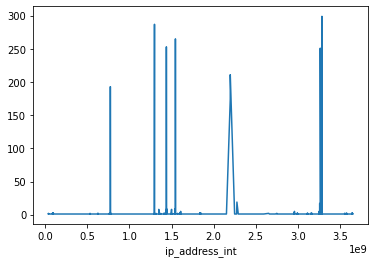

In [11]:
df.groupby(['ip_address_int']).size().plot()
# на графике видны скачки, хотя их быть не должно

In [12]:
# очень активные пользователи (высокая активность с одного IP-адреса)
ips = df.groupby(['ip_address_int']).size().to_dict()
ips = [k for k, v in ips.items() if v > 1]
df.loc[df.ip_address_int.isin(ips), 'flag'] = True

In [13]:
# источник совпадает с ссылкой
df.loc[(df.source == df.referer) | (df.sub_source == df.referer) | (df.sub_source_2 == df.referer) | (df.sub_source_3 == df.referer), 'flag'] = True

In [14]:
# мало новых пользователей, то есть ходят одни и те же
# здесь нужно посмотреть на какие источники ходят одни и те же fingerprint
df.groupby(['source', 'fingerprint']).size().mode()


0    1
dtype: int64

In [15]:
df.groupby(['source', 'fingerprint']).size().sort_values(ascending=False)

source                            fingerprint                     
250820642ba26fc02d946cf504440fdf  66b6125631b826ac0f3b4caf308b25ad    1567
5d1b41825a5dbe6b588ab93c77bb9bc5  66b6125631b826ac0f3b4caf308b25ad    1329
1e2d9bfeaa5294cb4c94bd0891c2a993  190b30133a125ecf6d995ca35a3f1df7     389
250820642ba26fc02d946cf504440fdf  8306b77e0209cfff259fedf7ed16bc2f     216
e565eb7d382e99da8819f554f7b79b73  fba462c8894f1111b7efb1c67a094cf3     199
                                                                      ... 
8b8e744771bdb7b03f9ce9b7a8d65d48  3e80375b350e757e65e83f750ec23f1e       1
                                  37e3d1ba705f866a05e276a41e12a6d2       1
                                  335d4f282f86e9cd6966e6ce16e7ea4f       1
                                  310f38f3ffc4aae4d527ed26ccf8b03a       1
ff7cda2f5c1c2aec9734252e884f4c63  561f946eb7471e9733cfb993cb0c7e4f       1
Length: 2536, dtype: int64

In [16]:
# видно, что к источнику 250820642ba26fc02d946cf504440fdf зачастил 66b6125631b826ac0f3b4caf308b25ad

In [17]:
# пометим таким образом данные для всех источников и саб-источников

sources = ['source', 'sub_source', 'sub_source_2', 'sub_source_3']
for s in sources:
    source_fingerprint = df.groupby([s, 'fingerprint']).size().to_dict()
    source_fingerprint = [[k[0], k[1]] for k, v in source_fingerprint.items() if v > 1]
    df.loc[df[s].isin(source_fingerprint[0]) & df.fingerprint.isin(source_fingerprint[1]), 'flag'] = True

Теперь посмотрим распределения трафика с источников по времени
подозрительные действия будем искать среди ip_address_int, user_id, fingerprint, так как насколько я понимаю эти значения указывают на конкретного пользователя, а настоящий пользователь в один момент времени не может совершать более одного действия

In [18]:
df.groupby(['ip_address_int', 'click_timestamp']).size().mode()

0    1
dtype: int64

In [19]:
df.groupby(['user_id', 'click_timestamp']).size().mode()

0    1
dtype: int64

In [20]:
df.groupby(['fingerprint', 'click_timestamp']).size().mode()

0    1
dtype: int64

In [21]:
sources = ['ip_address_int', 'user_id', 'fingerprint']
for s in sources:
    source_click_timestampt = df.groupby([s, 'click_timestamp']).size().to_dict()
    source_click_timestamp = [[k[0], k[1]] for k, v in source_click_timestampt.items() if v > 1]
    df.loc[df[s].isin(source_click_timestamp[0]) & df.click_timestamp.isin(source_click_timestamp[1]), 'flag'] = True

In [22]:
# процент аномальных данных в датасете
# остается надеяться, что это не реальные данные, а то получается страшно много фрода (страшно интересно)
print(f"{round(df.groupby(['flag']).size()[True]/ df.shape[0] * 100, 2)}%")

42.63%
